<center>
    <h1> Natural Language Processing</h1>
    <h2> Assignment 1 </h2>
    <a href="mailto:ildebrando.simeoni@studio.unibo.it">Ildebrando Simeoni</a>, <a href="mailto:diego.biagini2@studio.unibo.it">Diego Biagini</a>, <a href="mailto:matteo.donati10@studio.unibo.it">Matteo Donati</a>
</center>

<br>

Part-of-Speech (POS) tagging refers to the process of assigning a specific marker to each input token composing a given sentence. This process can also be seen as a disambiguation task. Indeed, the same token can be assigned a different marker, or tag, depending on the syntactical role the token plays in the given sentence.

This notebook performs POS tagging on a NLTK dataset<sup>[[1]](#references)</sup> using different neural architectures and GloVe embeddings<sup>[[2]](#references)</sup>.

## Libraries

In [ ]:
# Importing os.
import os

# Importing urllib.request.
import urllib.request

# Importing zipfile.
import zipfile

# Importing pandas.
import pandas as pd

# Importing numpy.
import numpy as np

# Importing random.
import random

# Importing tensorflow.
import tensorflow as tf

# Importing pad_sequences.
from keras_preprocessing.sequence import pad_sequences

# Importing Sequential.
from keras.models import Sequential

# Importing Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation.
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation, GRU

# Importing L2.
from keras.regularizers import l2

# Importing Adam.
from keras.optimizers import Adam

# Importing EarlyStopping and ReduceLROnPlateau.
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Importing classification_report.
from sklearn.metrics import classification_report

# Importing pyplot.
import matplotlib.pyplot as plt

# Importing ConfusionMatrixDisplay.
from sklearn.metrics import ConfusionMatrixDisplay

# Importing normalize.
from sklearn.preprocessing import normalize

# Sets reproducibility.
def set_reproducibility(seed):

  # Setting seeds.
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  os.environ["TF_DETERMINISTIC_OPS"] = "1"
  os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

# Setting seed.
set_reproducibility(seed = 42)

## Data Analysis and Preprocessing

In [ ]:
# Function used to download .zips.
def downloader(url, folder_name, filename):

  # Defining data folder path.
  data_path = os.path.join(os.getcwd(), folder_name)

  # Creating data folder.
  if not os.path.exists(data_path):
      os.makedirs(data_path)

  # Defining .zip file path.
  zip_path = os.path.join(os.getcwd(), folder_name, filename)

  # Requesting .zip file.
  if not os.path.exists(zip_path):
      urllib.request.urlretrieve(url, zip_path)

  # Extracting data from .zip.
  with zipfile.ZipFile(zip_path, "r") as zip_ref:
      zip_ref.extractall(path = data_path)

  # Returning data_path and zip_path.
  return data_path, zip_path

In [ ]:
# Downloading dataset.
data_path, _ = downloader(url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip", folder_name = "data", filename = "dependency_treebank.zip")

# Downloading glove.
glove_path, _ = downloader(url = "https://nlp.stanford.edu/data/glove.6B.zip", folder_name = "glove", filename = "glove.6B.zip")

In [ ]:
# Defining the dataset name.
dataset_name = "dependency_treebank"

# Defining path to first training sample.
file_path = os.path.join(data_path, dataset_name, "wsj_0001.dp")

# Reading first training sample.
if os.path.isfile(file_path):

  # Printing file.
  with open(file_path, mode = "r") as text_file: print(text_file.read())

Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8

Mr.	NNP	2
Vinken	NNP	3
is	VBZ	0
chairman	NN	3
of	IN	4
Elsevier	NNP	7
N.V.	NNP	12
,	,	12
the	DT	12
Dutch	NNP	12
publishing	VBG	12
group	NN	5
.	.	3



In [ ]:
# Defining embedding size.
EMBEDDING_SIZE = 50

# Defining specific glove's file path.
glove_file = os.path.join(os.getcwd(), glove_path, f"glove.6B.{str(EMBEDDING_SIZE)}d.txt")

# Reading lines of file.
with open(glove_file, encoding = "utf8" ) as text_file: 
  lines = text_file.readlines()

# Defining initial vocabulary.
embedding_vocabulary = {}

# Reading single lines.
for line in lines:

  # Splitting line.
  splits = line.split()

  # Storing line into vocabulary.
  embedding_vocabulary[splits[0]] = np.array([float(val) for val in splits[1:]])

# Printing one entry of the vocabulary.
print("The embedding for 'the' is:\n{}.".format(embedding_vocabulary["the"]))

The embedding for 'the' is:
[ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01].


In [ ]:
# Function used to get a list of embeddings.
def get_embeddings(sentence, vocabulary, embedding_size):

  # List of embeddings for the input sentence.
  embeddings = []

  # Retrieving embedding vector for each word.
  for word in sentence:

    # Computing the embedding.
    embedding = vocabulary.get(word.lower())

    # Checking the embedding.
    if embedding is not None:
      
      # Populating the list of embeddings.
      embeddings.append(embedding)
    
    else:

      # Storing vector of zeros for OOV terms.
      embeddings.append(list(np.zeros(embedding_size)))

  # Returning list of embeddings.
  return embeddings

# List containing dataframe rows.
dataframe_rows = []

# List containing words of a single sentence.
row_words = []

# List containing tags of a single sentence.
row_tags = []

# Defining data folder path.
folder = os.path.join(data_path, dataset_name)

# Storing rows.
for filename in sorted(os.listdir(folder)):

  # Computing path to file.
  file_path = os.path.join(folder, filename)

  # Checking existance of file.
  if os.path.isfile(file_path):

    # Opening the file.
    with open(file_path, mode = "r") as text_file:

      # Reading lines.
      while True:

        # Reading next line.
        line = text_file.readline()

        # Checking that line is different from "\n" (empty line) and from last line (EOF).
        if line and line != "\n":

          # Storing the word.
          row_words.append(line.split()[0])

          # Storing the POS tag.
          row_tags.append(line.split()[1])

        # Creating new dataframe row.
        else:

          # Creating a row.
          dataframe_row = {"file_id": int(filename.split(".")[0].split("_")[1]), 
                           "sentence": row_words, 
                           "tags": row_tags, 
                           "features": get_embeddings(row_words, embedding_vocabulary, EMBEDDING_SIZE)}

          # Appending row.
          dataframe_rows.append(dataframe_row)

          # Resetting row_words list so to store a new sentence.
          row_words = []

          # Resetting row_tags list so to store a new sentence.
          row_tags = []

          # If, in particular, EOF is reached, then break the inner loop.
          if not line: break

# Creating pandas dataframe.
dataframe = pd.DataFrame(dataframe_rows)

# Printing dataframe head.
dataframe.head()

,file_id,sentence,tags,features
0,1,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...","[[0.23568, 0.39638, -0.60135, -0.52681, 0.1587..."
1,1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...","[[0.006008, 0.57028, -0.064426, -0.044687, 0.8..."
2,2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...","[[0.86274, 0.056588, -0.081828, -0.35318, -0.0..."
3,3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...","[[0.21705, 0.46515, -0.46757, 0.10082, 1.0135,..."
4,3,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...","[[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -..."


In [ ]:
# Defining training split.
TRAINING_SPLIT = range(1, 101)

# Defining validation split.
VALIDATION_SPLIT = range(101, 151)

# Defining test split.
TEST_SPLIT = range(151, 200)

# Computing train dataframe.
train = dataframe.loc[dataframe["file_id"].isin(TRAINING_SPLIT)]

# Computing validation dataframe.
validation = dataframe.loc[dataframe["file_id"].isin(VALIDATION_SPLIT)]

# Computing test dataframe.
test = dataframe.loc[dataframe["file_id"].isin(TEST_SPLIT)]

In [ ]:
# Printing total number of sentences.
print(f"The dataframe consists of {len(dataframe)} sentences:")

# Printing number of training sentences.
print(f" - {len(train)} of these sentences define the training set.")

# Printing number of validation sentences.
print(f" - {len(validation)} of these sentences define the validation set.")

# Printing number of test sentences.
print(f" - {len(test)} of these sentences define the test set.")

The dataframe consists of 3914 sentences:
 - 1963 of these sentences define the training set.
 - 1299 of these sentences define the validation set.
 - 652 of these sentences define the test set.


In [ ]:
# Computing length of longest train sentence.
MAX_LENGTH = len(max(train["sentence"].tolist(), key = len))

# Padding train features.
train_features = pad_sequences(train["features"].tolist(), maxlen = MAX_LENGTH, padding = "post", dtype = "float32")

# Padding validation features.
validation_features = pad_sequences(validation["features"].tolist(), maxlen = MAX_LENGTH, padding = "post", dtype = "float32")

# Padding test features.
test_features = pad_sequences(test["features"].tolist(), maxlen = MAX_LENGTH, padding = "post", dtype = "float32")

In [ ]:
# Storing all training tags. The training set already contains all of them.
train_tags = [item for sublist in train["tags"].tolist() for item in sublist]

# Storing all validation tags.
validation_tags = [item for sublist in validation["tags"].tolist() for item in sublist]

# Storing all test tags.
test_tags = [item for sublist in test["tags"].tolist() for item in sublist]

# Removing duplicates from train_tags. By using a dict instead of a set I can get reproducible results (sets are not ordered).
tags = list(dict.fromkeys(train_tags))

In [ ]:
# Punctuation tag list.
punctuation_tag_list = ["PAD", ",", ".", "``", "''", ":", "$", "-LRB-", "-RRB-", "SYM", "LS", "#"]

# Defining figures folder path.
figures_path = os.path.join(os.getcwd(), "figures")

# Creating data folder.
if not os.path.exists(figures_path): os.makedirs(figures_path)

# Function used to plot classes distribution.
def plot_classes_distribution(classes, counts, filename, figures_path = figures_path):

  # Defining figure.
  fig, ax = plt.subplots(1, 1, figsize = (9, 4))

  # Plotting counts.
  bars = ax.bar(np.arange(0, len(classes), 1), counts)

  # Setting opacity to punctuation bars.
  for i in range(len(classes)): 
    if classes[i] in punctuation_tag_list: bars[i].set_alpha(0.5)

  # Setting x label.
  ax.set_xlabel("Class")

  # Setting y label.
  ax.set_ylabel("Count")

  # Setting y scale.
  ax.set_yscale("log")

  # Setting xticks.
  ax.set_xticks(np.arange(0, len(classes), 1))

  # Setting xticklabels.
  ax.set_xticklabels(classes, rotation = 90)

  # Saving figure.
  fig.savefig(f"{figures_path}/{filename}_classes_distribution.pdf", bbox_inches = "tight")

  # Showing the plot.
  plt.show()

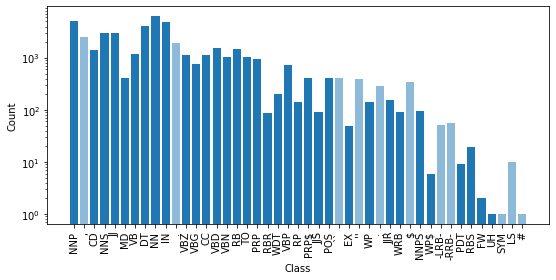

In [ ]:
# Computing classes counts.
training_counts = [train_tags.count(tag) for tag in tags]

# Plotting distribution.
plot_classes_distribution(tags, training_counts, "training")

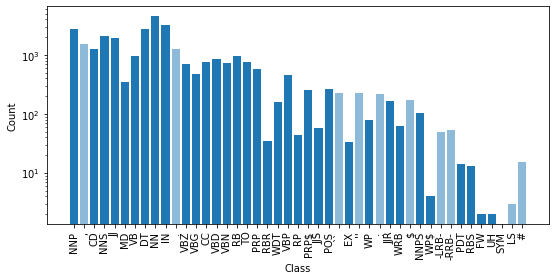

In [ ]:
# Computing classes counts.
validation_counts = [validation_tags.count(tag) for tag in tags]

# Plotting distribution.
plot_classes_distribution(tags, validation_counts, "validation")

In [ ]:
# Printing how many classes have zero support in the validation set.
print(f"The classes {[tags[tag_index] for tag_index in np.argwhere(np.array(validation_counts) == 0).flatten()]} have zero support in the validation set.")

The classes ['SYM'] have zero support in the validation set.


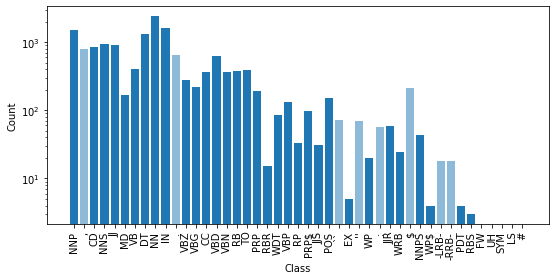

In [ ]:
# Computing classes counts.
test_counts = [test_tags.count(tag) for tag in tags]

# Plotting distribution.
plot_classes_distribution(tags, test_counts, "test")

In [ ]:
# Printing how many classes have zero support in the test set.
print(f"The classes {[tags[tag_index] for tag_index in np.argwhere(np.array(test_counts) == 0).flatten()]} have zero support in the test set.")

The classes ['FW', 'UH', 'SYM', 'LS', '#'] have zero support in the test set.


In [ ]:
# Vocabulary for tags.
tag_to_index = {}

# PAD is mapped onto 0.
tag_to_index["PAD"] = 0

# All other tags are mapped onto other indexes, starting from 1 up to |tags|.
for i, tag in enumerate(list(tags)): tag_to_index[tag] = i + 1

# Tag-to-index transformation and padding.
train_tags = [[tag_to_index[tag] for tag in tags_list] for tags_list in list(train["tags"])]

# Computing validation tags and padding.
validation_tags = [[tag_to_index[tag] for tag in tags_list] for tags_list in list(validation["tags"])]

# Computing test tags and padding.
test_tags = [[tag_to_index[tag] for tag in tags_list] for tags_list in list(test["tags"])]

# Padding train tags.
train_tags = pad_sequences(train_tags, maxlen = MAX_LENGTH, padding = "post")

# Padding validation tags.
validation_tags = pad_sequences(validation_tags, maxlen = MAX_LENGTH, padding = "post")

# Padding test tags.
test_tags = pad_sequences(test_tags, maxlen = MAX_LENGTH, padding = "post")

## Models Definition and Training

In [ ]:
# List of models' names.
models_name = ["m_0", "m_1", "m_2", "m_3"]

# Dictionary of models' description.
descriptions_dict = {models_name[0]: (f"Baseline model ({models_name[0]}): \n"
                                      " - Bi-directional LSTM layer. \n"
                                      " - Time-distributed dense layer. \n"
                                      " - Softmax activation function."),
                     models_name[1]: (f"BiGRU model ({models_name[1]}): \n"
                                      " - Bi-directional GRU layer. \n"
                                      " - Time-distributed dense layer. \n"
                                      " - Softmax activation function."),
                     models_name[2]: (f"Additional bi-directional LSTM model ({models_name[2]}): \n"
                                      " - Bi-directional LSTM layer. \n"
                                      " - Bi-directional LSTM layer. \n"
                                      " - Time-distributed dense layer. \n"
                                      " - Softmax activation function."),
                     models_name[3]: (f"Additional dense layer model ({models_name[3]}): \n"
                                      " - Bi-directional LSTM layer. \n"
                                      " - Time-distributed dense layer. \n"
                                      " - ReLU activation function. \n"
                                      " - Time-distributed dense layer. \n"
                                      " - Softmax activation function.")}

# Dictionary of models.
models = {}

In [ ]:
# Batch size.
BATCH_SIZE = 128

# Epochs.
EPOCHS = 100

# Initial learning rate.
LR = 0.01

# Weight decay parameter.
REG = 0.01

# Early stopping callback.
early_stopping = EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True)

# Reduce learning rate on plateau callback.
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", patience = 3, factor = 0.1)

In [ ]:
# Function that creates the model.
def get_model(name, layers, input_shape):

  # Sequential model.
  model = Sequential()

  # Adding input layer.
  model.add(InputLayer(input_shape = input_shape))

  # Adding layers.
  for layer in layers:

    # Adding layers.
    model.add(layer)
  
  # Output dense layer.
  model.add(TimeDistributed(Dense(len(tag_to_index), activation = "softmax")))

  # Adding a name to the model.
  model._name = name

  # Returning the model.
  return model

In [ ]:
# Function used to grid-search.
def grid_search(model_name, units, best_baseline_LSTM_units = None):

  # List of models obtained during grid-search.
  models = []

  # List of histories.
  histories = []

  # Printing description of the model.
  print(f"Grid-search, {model_name} model.")

  # Grid-search over possible number of units so to find the best model.
  for n in units:

    # Checking model name.
    if model_name == "m_0":

      # List of layers.
      layers = [Bidirectional(LSTM(n, return_sequences = True, recurrent_regularizer = l2(REG)))]
    
    elif model_name == "m_1":

      # List of layers.
      layers = [Bidirectional(GRU(n, return_sequences = True, recurrent_regularizer = l2(REG)))]

    elif model_name == "m_2" and best_baseline_LSTM_units != None:

      # List of layers.
      layers = [Bidirectional(LSTM(best_baseline_LSTM_units, return_sequences = True, recurrent_regularizer = l2(REG))),
                Bidirectional(LSTM(n, return_sequences = True, recurrent_regularizer = l2(REG)))]

    elif model_name == "m_3" and best_baseline_LSTM_units != None:

      # List of layers.
      layers = [Bidirectional(LSTM(best_baseline_LSTM_units, return_sequences = True, recurrent_regularizer = l2(REG))),
                TimeDistributed(Dense(n, activation = "relu"))]

    # Creating the double lstm model.
    model = get_model(name = model_name, layers = layers, input_shape = (MAX_LENGTH, EMBEDDING_SIZE))

    # Compiling.
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(LR), metrics = ["accuracy"])

    # Storing model.
    models.append(model)

    # Printing info.
    print(f"\nNumber of units: {n}.\n")

    # Printing summary.
    models[-1].summary()

    # Fitting the model.
    history = models[-1].fit(train_features, train_tags, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (validation_features, validation_tags), callbacks = [early_stopping, reduce_lr])

    # Storing history.
    histories.append(history)

  # Returning models and histories.
  return models, histories

In [ ]:
# Function used to compute macro F1-score.
def compute_F1_score(model, X, y, tag_to_index_vocabulary):

  # Computing predictions.
  pred = model.predict(X)

  # Computing classification report.
  report = classification_report(y.flatten(), 
                                 np.argmax(pred, axis = 2).flatten(), 
                                 labels = np.arange(0, len(tag_to_index_vocabulary), 1),
                                 target_names = list(tag_to_index_vocabulary.keys()),
                                 zero_division = 0,
                                 output_dict = True)

  # Macro F1-score without punctuation classes.
  macro_f1 = 0

  # Iterating over classes.
  for tag in list(tag_to_index_vocabulary.keys()):

    # Updating the macro F1-score.
    if tag not in punctuation_tag_list: macro_f1 = macro_f1 + report[tag]["f1-score"]

  # Dividing macro F1-score with the number of non-punctuation classes.
  macro_f1 = macro_f1 / (len(list(tag_to_index_vocabulary.keys())) - len(punctuation_tag_list))

  # Returning macro F1-score, predictions and report.
  return macro_f1, pred, report

In [ ]:
# Function used to get the best model among a set of models.
def get_best_model(models, units):

  # Computing F1-scores.
  f1_scores = [compute_F1_score(model, validation_features, validation_tags, tag_to_index)[0] for model in models]

  # Computing best number of units .
  best = units[np.argmax(f1_scores)]

  # Printing best number of units.
  print(f"The best number of units is: {best}.")

  # Returning the best model.
  return best, f1_scores, models[np.argmax(f1_scores)]

In [ ]:
# Function used to plot training losses.
def plot_training_loss(model_name, units, histories, figures_path = figures_path):

  # Computing best epoch for each model.
  best_epochs = [np.argmin(history.history["val_loss"]) + 1 for history in histories]

  # Creating the figure and axes.
  fig, ax = plt.subplots(1, 1, figsize = (4, 4))

  # Plotting every history.
  for i in range(len(units)):

    # Computing the x axis array.
    x = np.arange(1, len(histories[i].history["val_loss"]) + 1, 1)

    # Plotting validation loss.
    ax.plot(x, histories[i].history["val_loss"], label = r"${}^{}$".format(model_name, i + 1))

  # Setting labels.
  ax.set_ylabel("Loss")

  # Setting labels.
  ax.set_xlabel("Epoch")

  # Displying legend.
  ax.legend()

  # Saving the figure.
  fig.savefig(f"{figures_path}/val_loss_{model_name}.pdf", bbox_inches = "tight")

  # Showing the plot.
  plt.show

# Function used to plot f1_scores.
def plot_f1_scores(model_name, units, f1_scores, figures_path = figures_path):
  
  # Creating the figure and axes.
  fig, ax = plt.subplots(1, 1, figsize = (4, 4))

  # Plotting.
  ax.plot(np.arange(0, len(f1_scores), 1), f1_scores, marker = "o")

  # Setting labels.
  ax.set_ylabel(r"$F_1$-score")

  # Setting labels.
  ax.set_xlabel("Model")

  # Setting x ticks.
  ax.set_xticks(np.arange(0, len(f1_scores), 1))

  # Setting x ticks labels.
  ax.set_xticklabels([r"${}^{}$".format(model_name, i + 1) for i in range(len(units))])

  # Saving the figure.
  fig.savefig(f"{figures_path}/f1_scores_{model_name}.pdf", bbox_inches = "tight")

  # Showing the plot.
  plt.show

### Baseline Model ($m_0$)

In [ ]:
# Possible units.
baseline_units = [32, 64, 128, 256]

# Computing models and histories.
baseline_models, baseline_model_histories = grid_search(models_name[0], baseline_units)

Grid-search, m_0 model.

Number of units: 32.

Model: "m_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 249, 64)          21248     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 249, 46)          2990      
 ibuted)                                                         
                                                                 
Total params: 24,238
Trainable params: 24,238
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 10s 107ms/step - loss: 1.8719 - accuracy: 0.8906 - val_loss: 0.5530 - val_accuracy: 0.9305 - lr: 0.0100
Epoch 2/100
16/16 [==============================] - 1s 38ms/step - loss: 0.4803 - accuracy: 0.9394 - val_loss: 0.3939 

In [ ]:
# Storing best model.
baseline_best_units, baseline_f1_scores, models[models_name[0]] = get_best_model(baseline_models, baseline_units)

41/41 [==============================] - 1s 13ms/step
The best number of units is: 256.


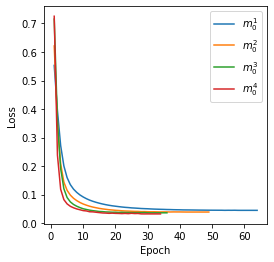

In [ ]:
# Plotting losses and saving figure as .pdf file.
plot_training_loss(models_name[0], baseline_units, baseline_model_histories)

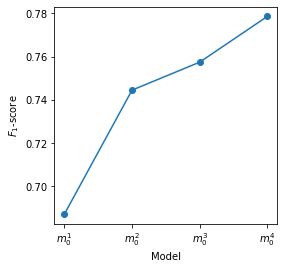

In [ ]:
# Plotting scores and saving figure as .pdf file.
plot_f1_scores(models_name[0], baseline_units, baseline_f1_scores)

### BiGRU Model ($m_1$)

In [ ]:
# Possible units.
gru_units = [32, 64, 128, 256]

# Computing models and histories.
gru_models, gru_model_histories = grid_search(models_name[1], gru_units)

Grid-search, m_1 model.

Number of units: 32.

Model: "m_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 249, 64)          16128     
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 249, 46)          2990      
 tributed)                                                       
                                                                 
Total params: 19,118
Trainable params: 19,118
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 4s 93ms/step - loss: 1.9700 - accuracy: 0.9153 - val_loss: 0.5253 - val_accuracy: 0.9415 - lr: 0.0100
Epoch 2/100
16/16 [==============================] - 1s 36ms/step - loss: 0.4526 - accuracy: 0.9465 - val_loss: 0.3506 - 

In [ ]:
# Storing best model.
_, gru_f1_scores, models[models_name[1]] = get_best_model(gru_models, gru_units)

41/41 [==============================] - 1s 14ms/step
The best number of units is: 256.


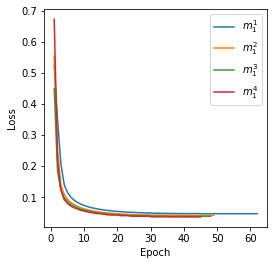

In [ ]:
# Plotting losses and saving figure as .pdf file.
plot_training_loss(models_name[1], gru_units, gru_model_histories)

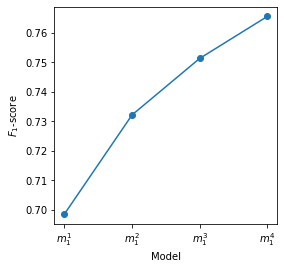

In [ ]:
# Plotting scores and saving figure as .pdf file.
plot_f1_scores(models_name[1], gru_units, gru_f1_scores)

### Additional BiLSTM Model ($m_2$)

In [ ]:
# Possible units.
double_lstm_units = [32, 64, 128, 256]

# Computing models and histories.
double_lstm_models, double_lstm_model_histories = grid_search(models_name[2], double_lstm_units, baseline_best_units)

Grid-search, m_2 model.

Number of units: 32.

Model: "m_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 249, 512)         628736    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 249, 64)          139520    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 249, 46)          2990      
 tributed)                                                       
                                                                 
Total params: 771,246
Trainable params: 771,246
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 9s 226ms/step - loss: 2

In [ ]:
# Storing best model.
_, double_lstm_f1_scores, models[models_name[2]] = get_best_model(double_lstm_models, double_lstm_units)

41/41 [==============================] - 2s 25ms/step
The best number of units is: 256.


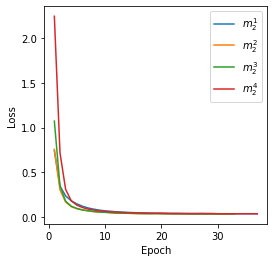

In [ ]:
# Plotting losses and saving figure as .pdf file.
plot_training_loss(models_name[2], double_lstm_units, double_lstm_model_histories)

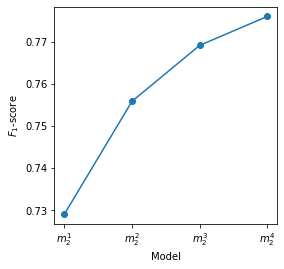

In [ ]:
# Plotting scores and saving figure as .pdf file.
plot_f1_scores(models_name[2], double_lstm_units, double_lstm_f1_scores)

### Additional Dense Layer Model ($m_3$)

In [ ]:
# Possible units.
double_dense_units = [32, 64, 128, 256]

# Computing models and histories.
double_dense_models, double_dense_model_histories = grid_search(models_name[3], double_dense_units, baseline_best_units)

Grid-search, m_3 model.

Number of units: 32.

Model: "m_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_16 (Bidirecti  (None, 249, 512)         628736    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 249, 32)          16416     
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 249, 46)          1518      
 stributed)                                                      
                                                                 
Total params: 646,670
Trainable params: 646,670
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 5s 149ms/step - loss: 2

In [ ]:
# Storing best model.
_, double_dense_f1_scores, models[models_name[3]] = get_best_model(double_dense_models, double_dense_units)

41/41 [==============================] - 1s 13ms/step
The best number of units is: 128.


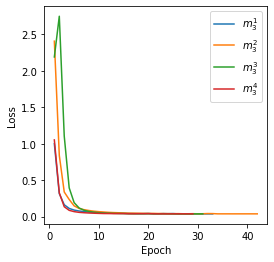

In [ ]:
# Plotting losses and saving figure as .pdf file.
plot_training_loss(models_name[3], double_dense_units, double_dense_model_histories)

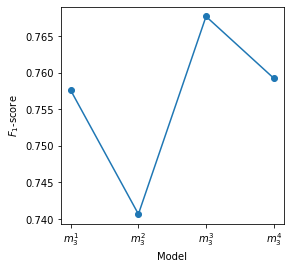

In [ ]:
# Plotting scores and saving figure as .pdf file.
plot_f1_scores(models_name[3], double_dense_units, double_dense_f1_scores)

## Models Testing

In [ ]:
# Best models validation macro F1-scores.
models_val_score = {}

# Best models validation predictions.
best_val_pred = {}

# Best models validation report.
models_val_report = {}

# Computing macro F1-scores on the four models selected with grid-search.
for model in models:

  # Printing the description of the two best models.
  print(f"{descriptions_dict[model]}\n")

  # Computing macro F1-score.
  models_val_score[model], best_val_pred[model], models_val_report[model] = compute_F1_score(models[model], validation_features, validation_tags, tag_to_index)

  # Computing and printing macro F1-score.
  print(f"The macro F1-score for model {model} is: {models_val_score[model]}.\n")

# Storing the two best models.
best_models = sorted(models_val_score, key = models_val_score.get, reverse = True)[:2]

Baseline model (m_0): 
 - Bi-directional LSTM layer. 
 - Time-distributed dense layer. 
 - Softmax activation function.

41/41 [==============================] - 1s 12ms/step
The macro F1-score for model m_0 is: 0.7785212201881775.

BiGRU model (m_1): 
 - Bi-directional GRU layer. 
 - Time-distributed dense layer. 
 - Softmax activation function.

41/41 [==============================] - 1s 12ms/step
The macro F1-score for model m_1 is: 0.7654758586112104.

Additional bi-directional LSTM model (m_2): 
 - Bi-directional LSTM layer. 
 - Bi-directional LSTM layer. 
 - Time-distributed dense layer. 
 - Softmax activation function.

41/41 [==============================] - 1s 25ms/step
The macro F1-score for model m_2 is: 0.7759855892307915.

Additional dense layer model (m_3): 
 - Bi-directional LSTM layer. 
 - Time-distributed dense layer. 
 - ReLU activation function. 
 - Time-distributed dense layer. 
 - Softmax activation function.

41/41 [==============================] - 1s 13ms/step

In [ ]:
# Best models test macro F1-scores.
models_test_score = {}

# Best models test predictions.
best_test_pred = {}

# Best models test report.
models_test_report = {}

# Testing the two best models.
for model in best_models:

  # Printing the description of the two best models.
  print(f"{descriptions_dict[model]}\n")

  # Computing predictions and f1-score.
  models_test_score[model], best_test_pred[model], models_test_report[model] = compute_F1_score(models[model], test_features, test_tags, tag_to_index)

  # Printing macro F1-score.
  print(f"The macro F1-score, on the test set, for model {model} is: {models_test_score[model]}.\n")

Baseline model (m_0): 
 - Bi-directional LSTM layer. 
 - Time-distributed dense layer. 
 - Softmax activation function.

21/21 [==============================] - 0s 13ms/step
The macro F1-score, on the test set, for model m_0 is: 0.7828587014572577.

Additional bi-directional LSTM model (m_2): 
 - Bi-directional LSTM layer. 
 - Bi-directional LSTM layer. 
 - Time-distributed dense layer. 
 - Softmax activation function.

21/21 [==============================] - 1s 25ms/step
The macro F1-score, on the test set, for model m_2 is: 0.7570605033192873.



## Error Analysis

In [ ]:
# Function used to compute % of miss-classification.
def get_missclassification_percentage(true_labels, pred_labels, tag_to_index, punctuation_tag_list):

  # Computing punctuation tags indexes.
  punctuation_indexes = [tag_to_index[tag] for tag in punctuation_tag_list]

  # Computing labels mask. Only non-punctuation tags are set to True.
  mask = np.isin(true_labels, punctuation_indexes)

  # Deleting true labels corresponding to punctuation classes.
  true = np.delete(true_labels, mask)

  # Deleting pred labels corresponding to punctuation classes.
  pred = np.delete(pred_labels, mask)

  # Returning missclassification percentage.
  return np.sum(true != pred) / len(true)

# Plotting test distribution for each best model.
for model in best_models:

  # Flattening val prediction.
  model_val_pred = np.argmax(best_val_pred[model], axis = 2).flatten()

  # Printing validation missclassification percentage.
  print("The error rate, on the validation set, for model {} is: {}%.".format(model,
                                                                              get_missclassification_percentage(validation_tags.flatten(),
                                                                                                                model_val_pred,
                                                                                                                tag_to_index,
                                                                                                                punctuation_tag_list) * 100))

  # Flattening test predictions.
  model_test_pred = np.argmax(best_test_pred[model], axis = 2).flatten()

  # Printing test missclassification percentage.
  print("The error rate, on the test set, for model {} is: {}%.".format(model,
                                                                        get_missclassification_percentage(test_tags.flatten(),
                                                                                                          model_test_pred,
                                                                                                          tag_to_index,
                                                                                                          punctuation_tag_list) * 100))

The error rate, on the validation set, for model m_0 is: 10.472369140981215%.
The error rate, on the test set, for model m_0 is: 9.578824217607487%.
The error rate, on the validation set, for model m_2 is: 10.651103410541674%.
The error rate, on the test set, for model m_2 is: 10.207663059374086%.


In [ ]:
# Computing precision and recall of best models.
for model in best_models:

  # Macro val precision without punctuation classes.
  val_precision = 0

  # Macro test precision without punctuation classes.
  test_precision = 0

  # Macro val recall without punctuation classes.
  val_recall = 0

  # Macro test recall without punctuation classes.
  test_recall = 0

  # Iterating over classes.
  for tag in list(tag_to_index.keys()):

    # Checking tag to not be a punctuation tag.
    if tag not in punctuation_tag_list: 
      
      # Updating precision
      val_precision = val_precision + models_val_report[model][tag]["precision"]
      test_precision = test_precision + models_test_report[model][tag]["precision"]
      
      # Updating recall
      val_recall = val_recall + models_val_report[model][tag]["recall"]
      test_recall = test_recall + models_test_report[model][tag]["recall"]

  # Dividing precision with the number of non-punctuation classes.
  val_precision = val_precision / (len(list(tag_to_index.keys())) - len(punctuation_tag_list))
  test_precision = test_precision / (len(list(tag_to_index.keys())) - len(punctuation_tag_list))

  # Dividing recall with the number of non-punctuation classes.
  val_recall = val_recall / (len(list(tag_to_index.keys())) - len(punctuation_tag_list))
  test_recall = test_recall / (len(list(tag_to_index.keys())) - len(punctuation_tag_list))

  # Printing precision and recall.
  print(f"The macro precision, on the validation set, for model {model} is: {val_precision}.")
  print(f"The macro precision, on the test set, for model {model} is: {test_precision}.")
  print(f"The macro recall, on the validation set, for model {model} is: {val_recall}.")
  print(f"The macro recall, on the test set, for model {model} is: {test_recall}.")

The macro precision, on the validation set, for model m_0 is: 0.7949423599795876.
The macro precision, on the test set, for model m_0 is: 0.7859061522269339.
The macro recall, on the validation set, for model m_0 is: 0.7777471631723517.
The macro recall, on the test set, for model m_0 is: 0.7872453784448298.
The macro precision, on the validation set, for model m_2 is: 0.7818023887356176.
The macro precision, on the test set, for model m_2 is: 0.7604590701771063.
The macro recall, on the validation set, for model m_2 is: 0.779621377114252.
The macro recall, on the test set, for model m_2 is: 0.7612573746359459.


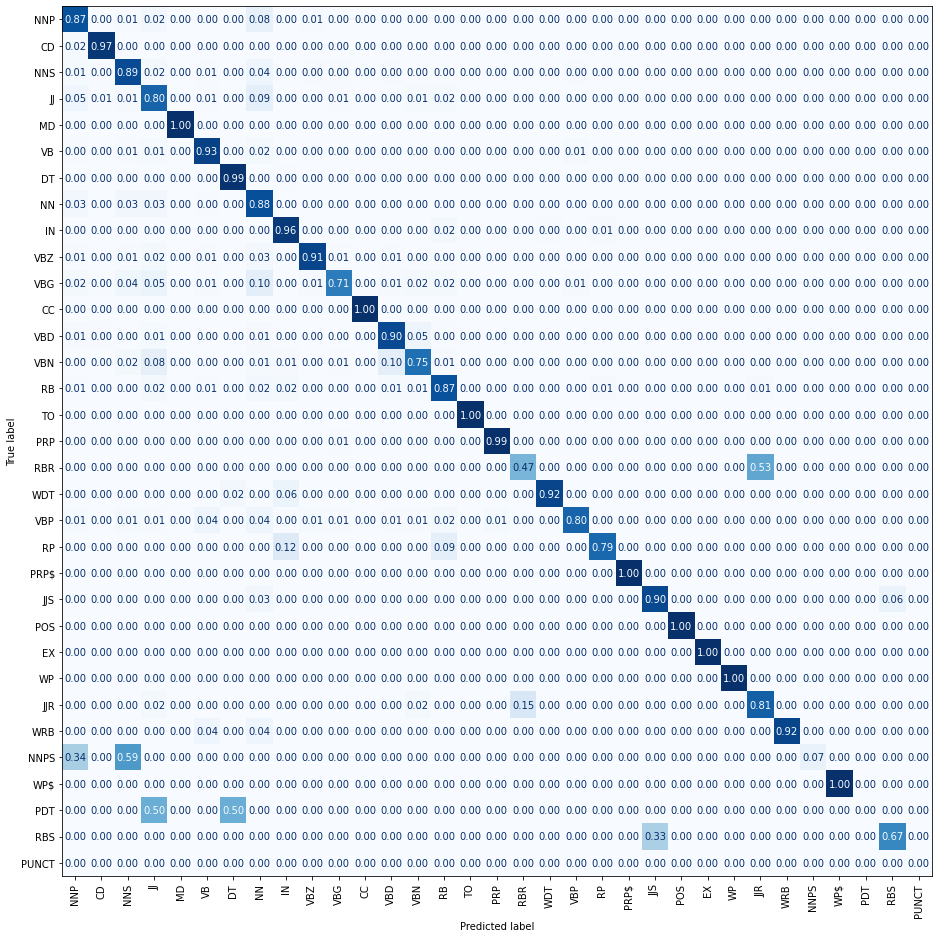

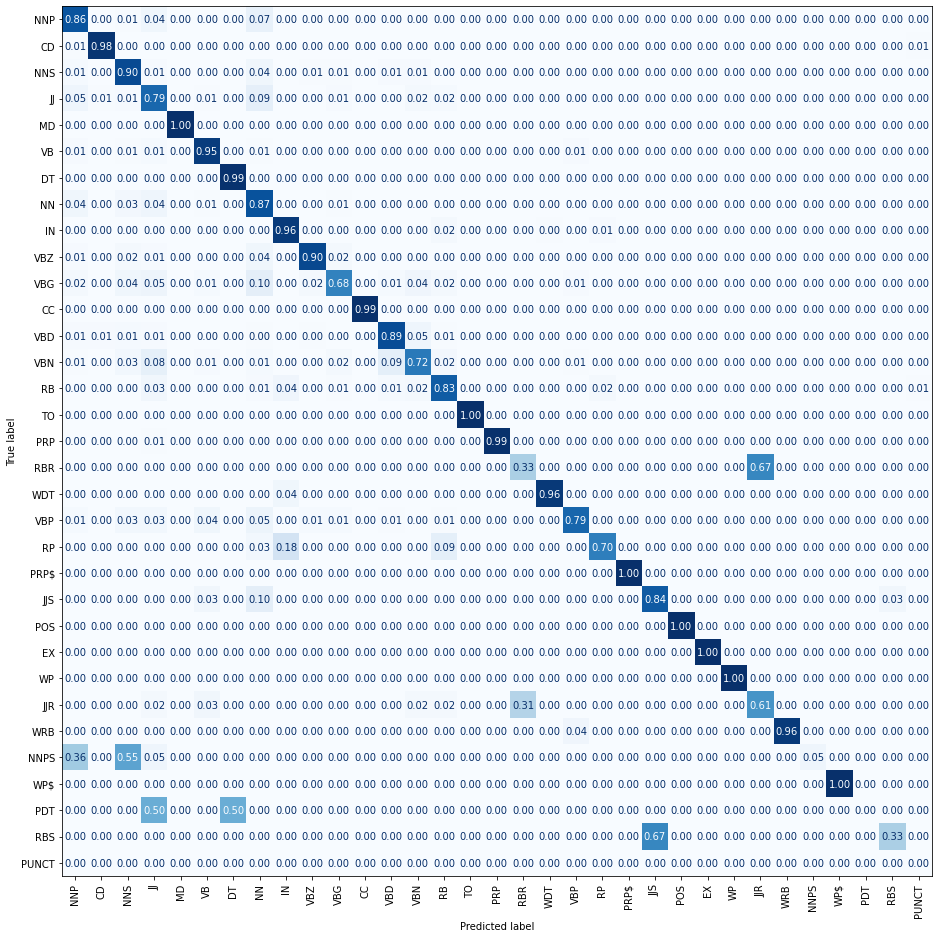

In [ ]:
def get_confusion_matrix(true_labels, pred_labels, punctuation_indexes, zero_support_indexes, n_classes, norm = None):

  # Computing labels mask. Only non-punctuation tags are set to True.
  mask = np.isin(true_labels, punctuation_indexes)

  # Deleting true labels corresponding to punctuation classes.
  true = np.delete(true_labels, mask)

  # Deleting pred labels corresponding to punctuation classes.
  pred = np.delete(pred_labels, mask)

  # Extract the different classes.
  true_classes = np.unique(true)

  # List containing indexes of punctuation tags or zero-support tags.
  to_be_removed = []

  # Computing punctuation tags indexes.
  to_be_removed.extend(punctuation_indexes)

  # Computing zero-support tags indexes. Index + 1 because of PAD tag.
  to_be_removed.extend(zero_support_indexes)

  # Eliminating duplicates from to_be_removed.
  to_be_removed = list(dict.fromkeys(to_be_removed))

  # Computing array of keys.
  keys = list(np.arange(0, n_classes, 1))

  # Computing array of values.
  values = list(np.arange(0, len(true_classes), 1))
  for i in to_be_removed:
    values.insert(i, -1)

  # Map dictionary used to build the confusion matrix without considering punctuation and zero-support.
  map = dict([(key, value) for key, value in zip(keys, values)])

  # Confusion matrix.
  confusion_matrix = np.zeros((len(true_classes) + 1, len(true_classes) + 1), dtype = int)

  # Iterate over labels.
  for i in range(len(true)):

    # Updating confusion matrix.
    confusion_matrix[map[true[i]], map[pred[i]]] = confusion_matrix[map[true[i]], map[pred[i]]] + 1

  # Normalizing by rows.
  if norm == "true": confusion_matrix = normalize(confusion_matrix, axis = 1, norm = "l1")

  # Normalizing by columns.
  if norm == "pred": confusion_matrix = normalize(confusion_matrix, axis = 0, norm = "l1")

  # Returning confusion matrix.
  return confusion_matrix, true_classes

# Computing punctuation indexes.
punctuation_indexes = [tag_to_index[tag] for tag in punctuation_tag_list]

# Computing zero-support indexes.
zero_support_indexes = [index + 1 for index in np.argwhere(np.array(test_counts) == 0).flatten()]

# Computing and plotting confusion matrix for each best model.
for model in best_models:

  # Print confusion matrix.
  confusion_matrix, true_classes = get_confusion_matrix(test_tags.flatten(),
                                                        np.argmax(best_test_pred[model], axis = 2).flatten(),
                                                        punctuation_indexes,
                                                        zero_support_indexes,
                                                        len(list(tag_to_index.keys())),
                                                        "true")

  # Computing labels.
  labels = [tag for index in true_classes for tag, value in tag_to_index.items() if value == index]
  labels.append("PUNCT")

  # Creating figure.
  fig, ax = plt.subplots(figsize = (16, 16))

  # Plotting confusion matrix.
  ConfusionMatrixDisplay(confusion_matrix, display_labels = labels).plot(ax = ax, cmap = plt.cm.Blues, xticks_rotation = "vertical", values_format = ".2f", colorbar = False)

  # Saving figure.
  fig.savefig(f"{figures_path}/confusion_matrix_{model}.pdf", bbox_inches = "tight")

  # Showing the plot.
  plt.show()

In [ ]:
# Computing error rates for all testing sentences.
error_rates = [get_missclassification_percentage(test_tags[i], np.argmax(best_test_pred["m_0"], axis = 2)[i], tag_to_index, punctuation_tag_list) * 100 for i in range(len(test_tags))]

# Number of top error rates.
TOP_ERROR_RATES = 5

# Computing the top three error rates
most_mistakes = np.argpartition(error_rates, -TOP_ERROR_RATES)[-TOP_ERROR_RATES:]

# Printing sentences, error rates, true tags and predicted tags.
for i in range(TOP_ERROR_RATES):

  # Printing sentence and error rate.
  print("The error rate for sentence {} is: {}%.".format(list(test["sentence"])[most_mistakes[i]], error_rates[most_mistakes[i]]))

  # Computing labels mask. Only non-punctuation tags are set to True.
  mask = np.isin(test_tags[most_mistakes[i]], punctuation_indexes)

  # Deleting true labels corresponding to punctuation classes.
  true = np.delete(test_tags[most_mistakes[i]], mask)

  # Converting index to tag.
  true = [tag for index in true for tag, value in tag_to_index.items() if value == index]

  # Deleting pred labels corresponding to punctuation classes.
  pred = np.delete(np.argmax(best_test_pred["m_0"], axis = 2)[most_mistakes[i]], mask)

  # Converting index to tag.
  pred = [tag for index in pred for tag, value in tag_to_index.items() if value == index]

  # Printing true tags.
  print("The true tags, without punctuation, are {}, while the predicted ones are {}.\n".format(true, pred))

The error rate for sentence ['Telerate', 'provides', 'an', 'electronic', 'financial', 'information', 'network', '.'] is: 42.857142857142854%.
The true tags, without punctuation, are ['NNP', 'VBZ', 'DT', 'JJ', 'JJ', 'NN', 'NN'], while the predicted ones are ['VBZ', 'VBZ', 'DT', 'JJ', 'NNP', 'NN', 'NNS'].

The error rate for sentence ['Wedtech', "'s", 'scammers', 'simply', 'bribed', 'them', 'to', 'shut', 'up', '.'] is: 44.44444444444444%.
The true tags, without punctuation, are ['NNP', 'POS', 'NNS', 'RB', 'VBD', 'PRP', 'TO', 'VB', 'IN'], while the predicted ones are ['NN', 'POS', 'NNS', 'PRP', 'VBD', 'PRP', 'TO', 'RB', 'RP'].

The error rate for sentence ['Business', ':', 'Savings', 'and', 'loan'] is: 50.0%.
The true tags, without punctuation, are ['NN', 'NNS', 'CC', 'NN'], while the predicted ones are ['NNP', 'NNS', 'CC', 'NNP'].

The error rate for sentence ['GRAINS', 'AND', 'SOYBEANS', ':'] is: 66.66666666666666%.
The true tags, without punctuation, are ['NNPS', 'NNP', 'NNPS'], while 

## References <a name="references"></a>

1. NLTK, Dependency Treebank, [https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip).

2. GloVe: Global Vectors for Word Representation, [https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove/).